Data loaded successfully.


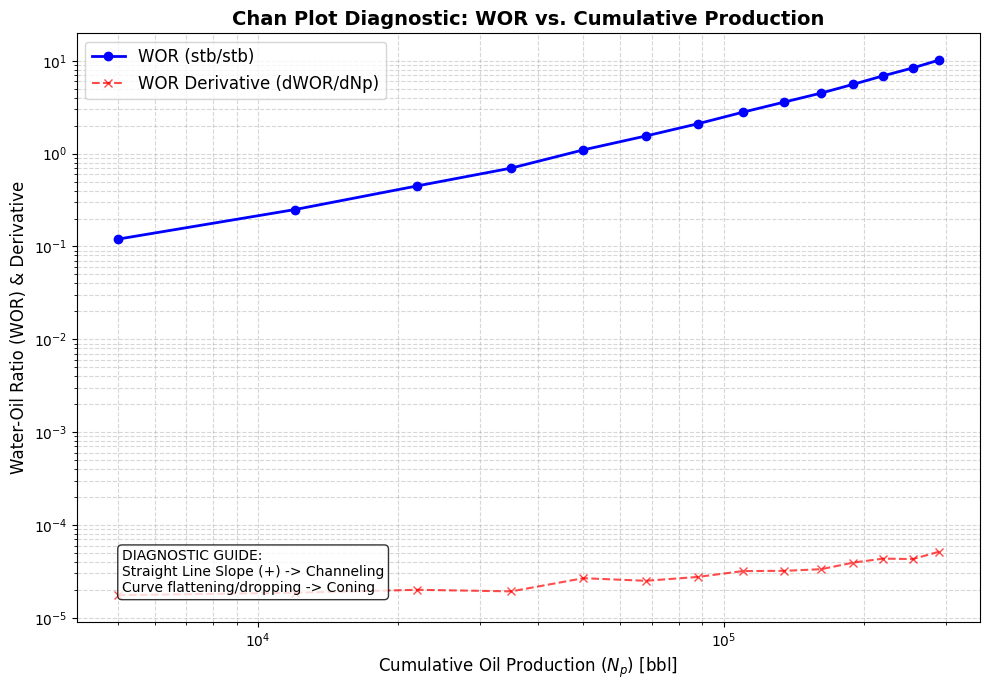

------------------------------
Analysis of recent trend (last 5 points):
Calculated Slope (b): 1.40
Interpretation: High slope suggests potential CHANNELING.
------------------------------


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Configuration ---
CSV_FILE = 'production_data.csv'

def calculate_wor_derivative(df):
    """
    Calculates the derivative of WOR with respect to Cumulative Production (Np).
    Formula: d(WOR) / d(Np)
    
    Note: In log-log analysis, we often look at the 'slope' of the WOR curve itself, 
    but calculating the explicit derivative helps visualize the rate of change.
    """
    # Calculate differences
    d_wor = np.diff(df['Water_Oil_Ratio'])
    d_np = np.diff(df['Cumulative_Oil_bbl'])
    
    # Avoid division by zero
    d_np[d_np == 0] = 1e-6
    
    # Calculate derivative
    derivative = d_wor / d_np
    
    # Since diff reduces array size by 1, we pad the beginning to match index
    derivative = np.insert(derivative, 0, np.nan) 
    
    return derivative

def plot_chan_diagnostic(df):
    """
    Generates the Log-Log Chan Plot.
    X-Axis: Cumulative Oil Production
    Y-Axis: WOR and WOR Derivative
    """
    fig, ax = plt.subplots(figsize=(10, 7))

    # 1. Plot WOR vs Cumulative Production
    ax.loglog(df['Cumulative_Oil_bbl'], df['Water_Oil_Ratio'], 
              marker='o', linestyle='-', color='b', label='WOR (stb/stb)', linewidth=2)

    # 2. Plot Derivative (Optional: Scaled for visibility if needed, or plotted as is)
    # Note: Derivatives can be noisy. In real-world cases, use a smoothing filter (e.g., Savitzky-Golay)
    ax.loglog(df['Cumulative_Oil_bbl'], df['WOR_Derivative'], 
              marker='x', linestyle='--', color='r', label="WOR Derivative (dWOR/dNp)", alpha=0.7)

    # Styling the plot
    ax.set_title("Chan Plot Diagnostic: WOR vs. Cumulative Production", fontsize=14, fontweight='bold')
    ax.set_xlabel("Cumulative Oil Production ($N_p$) [bbl]", fontsize=12)
    ax.set_ylabel("Water-Oil Ratio (WOR) & Derivative", fontsize=12)
    ax.grid(True, which="both", ls="--", alpha=0.5)
    ax.legend(fontsize=12)

    # --- Diagnostic Annotations (for educational purpose) ---
    # Ideally, these would be dynamic, but we place them to show the user how to read the plot.
    
    # Example Interpretation Text
    text_str = (
        "DIAGNOSTIC GUIDE:\n"
        "Straight Line Slope (+) -> Channeling\n"
        "Curve flattening/dropping -> Coning"
    )
    plt.text(0.05, 0.05, text_str, transform=ax.transAxes, fontsize=10,
             bbox=dict(facecolor='white', alpha=0.8, boxstyle='round'))

    plt.tight_layout()
    plt.show()

# --- Main Execution Flow ---

# 1. Load Data
try:
    df = pd.read_csv(CSV_FILE)
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"Error: {CSV_FILE} not found. Please ensure the CSV is in the same directory.")
    df = pd.DataFrame() # Create empty DF to prevent further errors

if not df.empty:
    # 2. Preprocessing
    # Ensure data is sorted by date/cumulative production
    df = df.sort_values(by='Cumulative_Oil_bbl')
    
    # 3. Calculate Derivative
    df['WOR_Derivative'] = calculate_wor_derivative(df)
    
    # Remove NaN values created by derivative calculation for cleaner plotting
    plot_data = df.dropna()

    # 4. Generate Plot
    plot_chan_diagnostic(plot_data)
    
    # 5. Simple Slope Check (Last 5 points)
    # Simple linear regression on Log-Log data to find the slope 'b'
    if len(plot_data) > 5:
        y_vals = np.log10(plot_data['Water_Oil_Ratio'].tail(5))
        x_vals = np.log10(plot_data['Cumulative_Oil_bbl'].tail(5))
        slope, intercept = np.polyfit(x_vals, y_vals, 1)
        
        print("-" * 30)
        print(f"Analysis of recent trend (last 5 points):")
        print(f"Calculated Slope (b): {slope:.2f}")
        
        if slope > 0.8:
            print("Interpretation: High slope suggests potential CHANNELING.")
        elif slope < 0.5:
             print("Interpretation: Lower slope suggests CONING or normal displacement.")
        else:
            print("Interpretation: Transition zone or inconclusive.")
        print("-" * 30)

# Smoothing Techniques for Rate-Derivative Analysis

## 📉 The Challenge: Noise in Derivative Calculations
In reservoir surveillance, diagnostic plots often require calculating the derivative of field data (e.g., $d(WOR)/d(N_p)$). Field data is inherently noisy due to measurement fluctuations, allocation factors, or operational intermittency.

Standard finite difference methods amplify this high-frequency noise, rendering the derivative curve unreadable.

## 🛠️ The Solution: Savitzky-Golay Filter
To address this, we utilize the **Savitzky-Golay** filter (also known as least-squares smoothing). Unlike a simple Moving Average (which flattens peaks and distorts signal onset), the Savitzky-Golay filter preserves features of the distribution such as relative maxima, minima, and width, which are critical for identifying flow regimes in Chan plots.

### Mathematical Concept
The filter applies a convolution process to successive sub-sets of adjacent data points with a low-degree polynomial by the method of linear least squares.

For a point $x_i$, the smoothed value $y_i$ is calculated by fitting a polynomial of order $k$ to a window of $2m+1$ points centered at $x_i$.

$$y_j = \sum_{i=-m}^{m} C_i \cdot y_{j+i}$$

Where:
* $2m+1$: The **Window Length** (must be an odd integer).
* $C_i$: Convolution coefficients derived from the least-squares fit of the polynomial.

### Implementation Parameters (Python/Scipy)
In the provided `ipynb`, we use `scipy.signal.savgol_filter` with the following tuning parameters:

1.  **Window Length (`window_length`):**
    * Controls the amount of smoothing.
    * *Too small:* Noise remains.
    * *Too large:* Physical trends (like the onset of coning) may be smoothed out.
    * *Default:* We typically use a window covering 5-15% of the data points.

2.  **Polynomial Order (`polyorder`):**
    * The degree of the polynomial used to fit the samples.
    * *Default:* Order 2 or 3 is sufficient for production decline trends.

### Why not Simple Moving Average (SMA)?
* **SMA** acts as a low-pass filter that effectively shifts the data timeline (lag) and degrades the sharpness of slope changes.
* **Savitzky-Golay** is preferred for Chan Plots because identifying the **exact slope** (channeling vs. coning) is the primary objective, and preserving the geometric integrity of the curve is paramount.

Data loaded successfully.


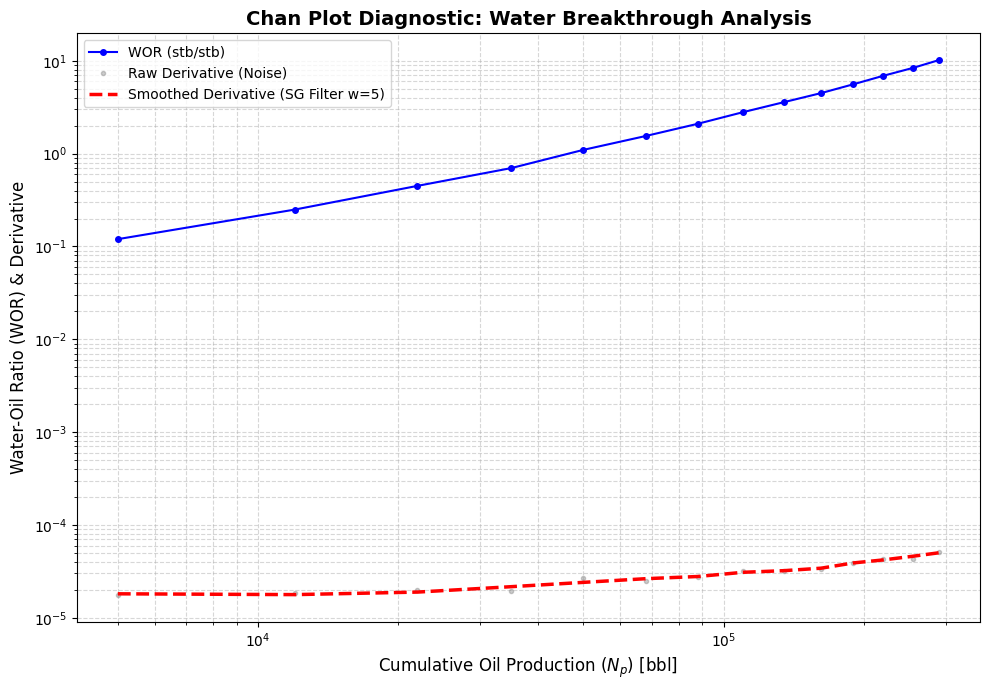


DIAGNOSTIC RESULT (Based on Smoothed Data)
Derivative Slope (m): 0.638
----------------------------------------
>> INDICATOR: WATER CONING
   Action: Evaluate critical rate vs current rate.
   Remediation: Rate reduction or chemical coning control.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

# --- Configuration ---
CSV_FILE = 'production_data.csv'

# Smoothing Parameters
# Window length must be odd and <= the size of valid data.
WINDOW_LENGTH = 5  
POLY_ORDER = 2     

def calculate_derivatives(df):
    """
    Calculates both Raw and Smoothed derivatives of WOR w.r.t Cumulative Production.
    """
    # 1. Calculate Standard Finite Difference (Raw)
    d_wor = np.diff(df['Water_Oil_Ratio'])
    d_np = np.diff(df['Cumulative_Oil_bbl'])
    
    # Avoid division by zero
    d_np[d_np == 0] = 1e-6
    
    raw_derivative = d_wor / d_np
    
    # Pad to match length
    raw_derivative = np.insert(raw_derivative, 0, np.nan)
    
    # 2. Apply Savitzky-Golay Smoothing
    # We smooth the calculated raw derivative, NOT the WOR data itself, 
    # to specifically tackle derivative noise.
    
    # Handle edge case where data is too short for the defined window
    effective_window = WINDOW_LENGTH
    if len(df) < WINDOW_LENGTH:
        effective_window = len(df) if len(df) % 2 != 0 else len(df) - 1
        if effective_window < 3: effective_window = 3 # Minimum for polyorder 2

    # We must operate on non-NaN data for the filter
    valid_mask = ~np.isnan(raw_derivative)
    smoothed_derivative = np.full(raw_derivative.shape, np.nan)
    
    if np.sum(valid_mask) > effective_window:
        smoothed_derivative[valid_mask] = savgol_filter(
            raw_derivative[valid_mask], 
            window_length=effective_window, 
            polyorder=POLY_ORDER
        )
    else:
        # Fallback if data is too sparse
        smoothed_derivative = raw_derivative

    return raw_derivative, smoothed_derivative

def plot_chan_diagnostic(df):
    """
    Generates the Log-Log Chan Plot with Smoothing.
    """
    fig, ax = plt.subplots(figsize=(10, 7))

    # 1. Plot WOR vs Cumulative Production (Primary Trend)
    ax.loglog(df['Cumulative_Oil_bbl'], df['Water_Oil_Ratio'], 
              marker='o', markersize=4, linestyle='-', color='blue', 
              label='WOR (stb/stb)', linewidth=1.5)

    # 2. Plot RAW Derivative (Faint, to show noise)
    ax.loglog(df['Cumulative_Oil_bbl'], df['WOR_Derivative_Raw'], 
              linestyle='None', marker='.', color='gray', alpha=0.4, 
              label="Raw Derivative (Noise)")

    # 3. Plot SMOOTHED Derivative (Bold, for interpretation)
    ax.loglog(df['Cumulative_Oil_bbl'], df['WOR_Derivative_Smooth'], 
              linestyle='--', color='red', linewidth=2.5, 
              label=f"Smoothed Derivative (SG Filter w={WINDOW_LENGTH})")

    # Styling
    ax.set_title("Chan Plot Diagnostic: Water Breakthrough Analysis", fontsize=14, fontweight='bold')
    ax.set_xlabel("Cumulative Oil Production ($N_p$) [bbl]", fontsize=12)
    ax.set_ylabel("Water-Oil Ratio (WOR) & Derivative", fontsize=12)
    ax.grid(True, which="both", ls="--", alpha=0.5)
    ax.legend(fontsize=10, loc='best')

    plt.tight_layout()
    plt.show()

# --- Main Execution Flow ---

# 1. Load Data
try:
    df = pd.read_csv(CSV_FILE)
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"Error: {CSV_FILE} not found.")
    df = pd.DataFrame() 

if not df.empty:
    # 2. Sort Data
    df = df.sort_values(by='Cumulative_Oil_bbl')
    
    # 3. Calculate Derivatives (Raw & Smooth)
    raw, smooth = calculate_derivatives(df)
    df['WOR_Derivative_Raw'] = raw
    df['WOR_Derivative_Smooth'] = smooth
    
    # 4. Generate Plot
    # Filter out NaNs for plotting to avoid matplotlib warnings
    plot_data = df.dropna()
    plot_chan_diagnostic(plot_data)
    
    # 5. Diagnostic Interpretation (Based on Smoothed Data)
    if len(plot_data) > 5:
        # Regression on the last few points of the SMOOTHED derivative
        y_vals = np.log10(plot_data['WOR_Derivative_Smooth'].tail(5))
        x_vals = np.log10(plot_data['Cumulative_Oil_bbl'].tail(5))
        
        # Polyfit returns [slope, intercept]
        slope, intercept = np.polyfit(x_vals, y_vals, 1)
        
        print("\n" + "="*40)
        print(f"DIAGNOSTIC RESULT (Based on Smoothed Data)")
        print(f"Derivative Slope (m): {slope:.3f}")
        print("-" * 40)
        
        if slope >= 0.9: # Theoretical slope for channeling is ~1.0
            print(">> INDICATOR: WATER CHANNELING (High Perm Layer)")
            print("   Action: Check geology for fractures/high-k streaks.")
            print("   Remediation: Polymer gel or mechanical shut-off.")
        elif -0.5 <= slope < 0.9:
            print(">> INDICATOR: WATER CONING")
            print("   Action: Evaluate critical rate vs current rate.")
            print("   Remediation: Rate reduction or chemical coning control.")
        else:
            print(">> INDICATOR: NORMAL DISPLACEMENT or Inconclusive")
        print("="*40)